In [1]:
import seaborn as sns
import statsmodels.tsa.stattools as ts 
import statsmodels.api as sm
from numpy import log, polyfit, sqrt, std, subtract
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import *

import pyfolio as pf

import ffn


from backtester import backtest as bt
from backtester import backtest_with_cost as btwc

%matplotlib inline

In [2]:
def create_pairs(tickers):
        result = []
        for p1 in range(len(tickers)):
                for p2 in range(p1+1,len(tickers)):
                        result.append([tickers[p1],tickers[p2]])
        return result
    
def get_closing(temp, name):
    temp.DATE = pd.to_datetime(temp['DATE'].str[:10], dayfirst=True)
    temp = temp.set_index(temp.DATE)
    
    temp.columns = ['Date', 'Symbol', 'Interval', 'Open', 'High', 'Low', name, 'Volume']
    temp = temp[name]
    return temp

    
def find_ssd(df, pairs):
    ssd = {}
    for p in pairs:
        pair = p[0]+','+p[1]
        A = df[p[0]]
        B = df[p[1]]
        s = np.sum((A-B)**2)
        
        if s == 0.0:
            #s = 999.9 
            continue
        
        if len(A.dropna()) < 248 or len(B.dropna()) < 248:
            #s = 999.9
            continue
            
        ssd[pair] = s
        
    return ssd


def find_tradeble_pairs(ssd, amount):
    sorted_lst = sorted(ssd, key=ssd.get)
    pair_lst = []
    if len(sorted_lst) < 1:
        return pair_lst
    for n in range(amount):
        pair_lst.append(sorted_lst[n].split(","))
    
    return pair_lst


def find_entry_exit(spread, n):
    mean = np.mean(spread)
    stdev = np.std(spread)
    upper = mean+(n*stdev)
    lower = mean+(n*stdev)
    
    return mean, upper, lower

def create_signal(df, pair, m, u, l):
    spread = df[pair[0]] - df[pair[1]]
    previous_spread = spread.shift(1)
    bt_df = pd.DataFrame()
    
    bt_df[pair[0]] = df[pair[0]]
    bt_df[pair[1]] = df[pair[1]]
    bt_df['shortsignal'] = ((spread < u) & (previous_spread > u))
    bt_df['longsignal'] = ((spread > l) & (previous_spread < l))
    bt_df['closelong'] = np.where(spread > m, 1, 0)
    bt_df['closeshort'] = np.where(spread < m, 1, 0)
    
    return bt_df


def trading(df_formation, df_trading, amount, n):
    returns = pd.DataFrame()
    
    ssd = find_ssd(df_formation, pairs)
    selected = find_tradeble_pairs(ssd, amount)
    
    for pair in selected:
        bt_name = pair[0]+pair[1]
        
        spread = df_formation[pair[0]] - df_formation[pair[1]]
        m, u, l = find_entry_exit(spread, n) 
        
        bt_df = create_signal(df_trading, pair, m, u, l)
        ret = btwc(bt_df, pair[0], pair[1])
        
        returns[bt_name] = ret.returns
        print(pair)
        
    returns['mean'] = returns.mean(axis=1)
    returns = returns.set_index(df_trading.index)
    return returns['mean']
    
    

def backtest(df, amount, n):
    overall_ret = pd.DataFrame()
    
    start = pd.Timestamp('2000-01')
    mid = start + relativedelta(months=+12)
    end = start + relativedelta(months=+18)
    
    df_formation = (1 + df[start:mid].pct_change()).cumprod()
    df_trading = (1 + df[mid:end].pct_change()).cumprod()
    
    returns = trading(df_formation, df_trading, amount, n)
    overall_ret = returns
    
    print(start, mid, end)

    for period in range(1, 38):
        start = start + relativedelta(months=+6)
        mid = start + relativedelta(months=+12)
        end = start + relativedelta(months=+18)
        
        df_formation = (1 + df[start:mid].pct_change()).cumprod()
        df_trading = (1 + df[mid:end].pct_change()).cumprod()

        returns = trading(df_formation, df_trading, amount, n)
        overall_ret = overall_ret.append(returns)

        print(start, mid, end)
        
    return overall_ret

In [3]:
tickers = pd.read_excel('C:/Users/jango/Documents/BFH/BTHE/Sectors.xlsx', sheet_name=None)

hc_tickers = tickers['Health Care'].Ticker.tolist()
cg_tickers = tickers['Consumer Goods'].Ticker.tolist()
fin_tickers = tickers['Financials'].Ticker.tolist()
ind_tickers = tickers['Industrials'].Ticker.tolist()
all_tickers = tickers['All'].Ticker.tolist()

In [62]:
UBS = pd.read_csv('C:/Users/jango/code/research_env/BTHE/Datalink/csv/UBSG.csv', delimiter=";")
UBS.DATE = pd.to_datetime(UBS['DATE'].str[:10], dayfirst=True)
df = pd.DataFrame(UBS.CLOSE).set_index(UBS.DATE)
df.columns = ['UBS']

In [63]:
pairs = create_pairs(all_tickers)

In [56]:
for ticker in ind_tickers:
    path = 'C:/Users/jango/code/research_env/BTHE/Datalink/csv/'+ticker+'.csv'
    df = df.join(get_closing(pd.read_csv(path, delimiter=";"), ticker)).ffill()
    #print(ticker + ' done')

In [57]:
df = df.drop(columns=['UBS'])
df.tail()

,ABBN,ADEN,ADVN,AFP,ARBN,BEAN,BOBNN,BOSN,BUCN,BCHN,...,SIGN,SIKA,SRAIL,STGN,SUN,TOHN,VACN,VET,ROL,ZEHN
DATE,,,,,,,,,,,,,,,,,,,,,
2020-03-12,15.740,36.50,145.0,18.26,7.85,5440.0,36.76,103.2,253.0,172.4,...,12.72,138.45,39.86,42.0,61.85,3.905,119.25,2290.0,0.660,35.55
2020-03-13,15.765,35.67,135.0,16.00,7.66,5280.0,37.56,101.4,248.0,160.8,...,13.30,143.45,39.74,42.0,60.75,3.605,118.65,2340.0,0.620,35.20
2020-03-16,15.160,33.81,135.0,13.30,7.52,5090.0,36.44,98.5,241.6,153.2,...,13.08,135.45,39.74,38.0,57.65,3.600,111.00,2105.0,0.600,33.70
2020-03-17,15.560,33.55,133.0,12.50,7.21,4920.0,37.64,99.9,258.6,159.8,...,12.42,143.40,39.30,39.8,54.80,3.385,107.65,2520.0,0.600,34.90
2020-03-18,15.045,33.21,120.0,12.12,6.50,5280.0,39.92,101.6,246.0,152.2,...,11.80,134.80,41.52,37.8,44.34,3.575,107.90,2300.0,0.532,34.15


In [174]:
pairs = create_pairs(['UHR', 'UHRN', 'ABBN', 'LISN', 'LISP'])
dfuhr = pd.DataFrame()
dfuhr['UHR'] = df['UHR']
dfuhr['UHRN'] = df['UHRN']
dfuhr['ABBN'] = df['ABBN']
dfuhr['LISN'] = df['LISN']
dfuhr['LISP'] = df['LISP']
ret = backtest(dfuhr, 1)
cum_ret = ret.cumsum() + 1

LISN LISP :  0 trades were made
['LISN', 'LISP']
2000-01-01 00:00:00 2001-01-01 00:00:00 2001-07-01 00:00:00
LISN LISP :  1 trades were made
['LISN', 'LISP']
2000-07-01 00:00:00 2001-07-01 00:00:00 2002-01-01 00:00:00
LISN LISP :  3 trades were made
['LISN', 'LISP']
2001-01-01 00:00:00 2002-01-01 00:00:00 2002-07-01 00:00:00
LISN LISP :  3 trades were made
['LISN', 'LISP']
2001-07-01 00:00:00 2002-07-01 00:00:00 2003-01-01 00:00:00
LISN LISP :  1 trades were made
['LISN', 'LISP']
2002-01-01 00:00:00 2003-01-01 00:00:00 2003-07-01 00:00:00
UHR UHRN :  1 trades were made
['UHR', 'UHRN']
2002-07-01 00:00:00 2003-07-01 00:00:00 2004-01-01 00:00:00
UHR UHRN :  2 trades were made
['UHR', 'UHRN']
2003-01-01 00:00:00 2004-01-01 00:00:00 2004-07-01 00:00:00
UHR UHRN :  2 trades were made
['UHR', 'UHRN']
2003-07-01 00:00:00 2004-07-01 00:00:00 2005-01-01 00:00:00
UHR UHRN :  1 trades were made
['UHR', 'UHRN']
2004-01-01 00:00:00 2005-01-01 00:00:00 2005-07-01 00:00:00
UHR UHRN :  0 trades were m

In [58]:
amounts = [2, 5, 10]
n = [0.5, 1.0 , 1.5, 2.0]
master_lst = {}
master_cum = {}

for number in n:
    for amount in amounts:
        name = '{}ssd{}std'.format(amount, number)
        ret = backtest(df, amount, number)
        master_lst[name] = ret
        master_cum[name] = ret.cumsum() + 1

SCHN SCHP :  8 trades were made
['SCHN', 'SCHP']
GEBN STRN :  12 trades were made
['GEBN', 'STRN']
2000-01-01 00:00:00 2001-01-01 00:00:00 2001-07-01 00:00:00
SCHN SCHP :  20 trades were made
['SCHN', 'SCHP']
STRN SIKA :  9 trades were made
['STRN', 'SIKA']
2000-07-01 00:00:00 2001-07-01 00:00:00 2002-01-01 00:00:00
SCHN SCHP :  21 trades were made
['SCHN', 'SCHP']
SCHP VET :  5 trades were made
['SCHP', 'VET']
2001-01-01 00:00:00 2002-01-01 00:00:00 2002-07-01 00:00:00
SCHN SCHP :  0 trades were made
['SCHN', 'SCHP']
DAE RIEN :  7 trades were made
['DAE', 'RIEN']
2001-07-01 00:00:00 2002-07-01 00:00:00 2003-01-01 00:00:00
SCHN SCHP :  0 trades were made
['SCHN', 'SCHP']
CONN DAE :  21 trades were made
['CONN', 'DAE']
2002-01-01 00:00:00 2003-01-01 00:00:00 2003-07-01 00:00:00
SCHN SCHP :  19 trades were made
['SCHN', 'SCHP']
RIEN STGN :  0 trades were made
['RIEN', 'STGN']
2002-07-01 00:00:00 2003-07-01 00:00:00 2004-01-01 00:00:00
GEBN SIKA :  3 trades were made
['GEBN', 'SIKA']
BOBN

In [58]:
for n in master_lst:
    name = '{}ssd2.0std'.format(n)
    master_cum[name] = master_lst[n].cumsum() + 1

In [110]:
#master_df = pd.DataFrame({'2': master_cum[2], '5': master_cum[5], '10': master_cum[10]})

In [60]:
master_df = pd.DataFrame(master_cum)
master_df.to_csv('results_industrials_wc.csv')

In [59]:
perf = pd.DataFrame(master_cum).calc_stats()
perf.set_riskfree_rate(0.019)
perf.display()

Stat                 2ssd0.5std    5ssd0.5std    10ssd0.5std    2ssd1.0std    5ssd1.0std    10ssd1.0std    2ssd1.5std    5ssd1.5std    10ssd1.5std    2ssd2.0std    5ssd2.0std    10ssd2.0std
-------------------  ------------  ------------  -------------  ------------  ------------  -------------  ------------  ------------  -------------  ------------  ------------  -------------
Start                2001-01-03    2001-01-03    2001-01-03     2001-01-03    2001-01-03    2001-01-03     2001-01-03    2001-01-03    2001-01-03     2001-01-03    2001-01-03    2001-01-03
End                  2019-12-30    2019-12-30    2019-12-30     2019-12-30    2019-12-30    2019-12-30     2019-12-30    2019-12-30    2019-12-30     2019-12-30    2019-12-30    2019-12-30
Risk-free rate       1.90%         1.90%         1.90%          1.90%         1.90%         1.90%          1.90%         1.90%         1.90%          1.90%         1.90%         1.90%

Total Return         -17.26%       10.12%        39.79%

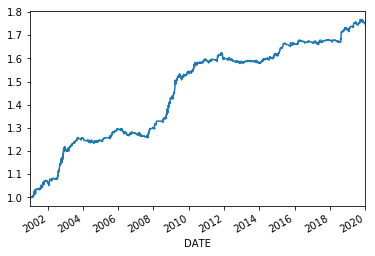

In [61]:
master_cum['10ssd2.0std'].plot.line()

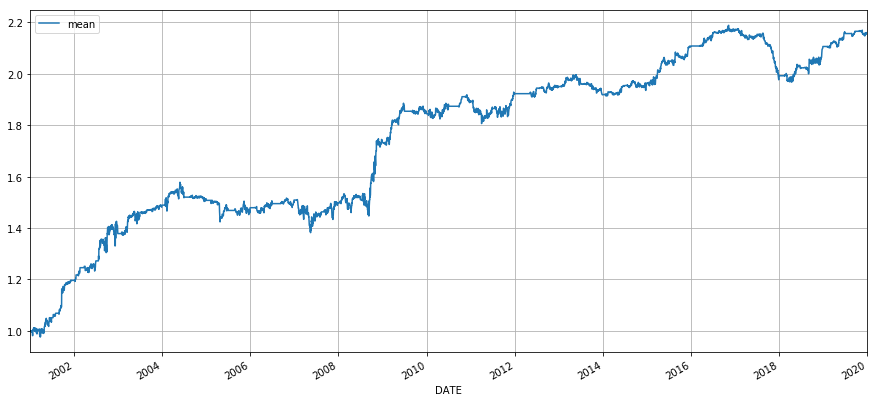

In [32]:
total_ret = pd.DataFrame(ret.cumsum() + 1)
total_ret.plot(figsize=(15,7),grid=True)

In [33]:
perf = total_ret.calc_stats() 
perf.display()

Stat                 mean
-------------------  ----------
Start                2001-01-03
End                  2019-12-30
Risk-free rate       0.00%

Total Return         115.98%
Daily Sharpe         0.65
Daily Sortino        1.11
CAGR                 4.14%
Max Drawdown         -12.43%
Calmar Ratio         0.33

MTD                  0.23%
3m                   -0.24%
6m                   0.08%
YTD                  2.56%
1Y                   2.56%
3Y (ann.)            -0.20%
5Y (ann.)            1.92%
10Y (ann.)           1.59%
Since Incep. (ann.)  4.14%

Daily Sharpe         0.65
Daily Sortino        1.11
Daily Mean (ann.)    4.27%
Daily Vol (ann.)     6.62%
Daily Skew           2.05
Daily Kurt           36.06
Best Day             6.36%
Worst Day            -3.73%

Monthly Sharpe       0.80
Monthly Sortino      1.87
Monthly Mean (ann.)  4.19%
Monthly Vol (ann.)   5.22%
Monthly Skew         1.62
Monthly Kurt         7.70
Best Month           8.94%
Worst Month          -4.21%

Yearly Shar

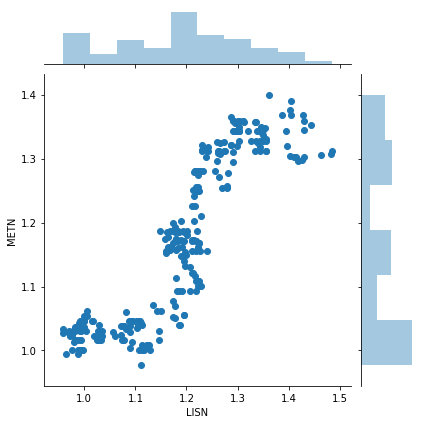

In [15]:
sns.jointplot(x="LISN", y="METN", data=df_ind['2005-01':'2006-01'])

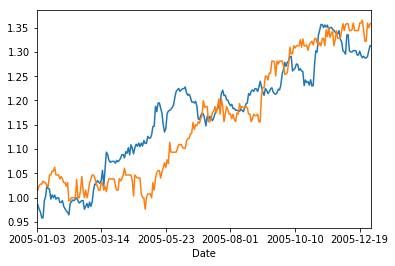

In [159]:
df_ind['LISN']['2005-01':'2006-01'].plot()
df_ind['METN']['2005-01':'2006-01'].plot()

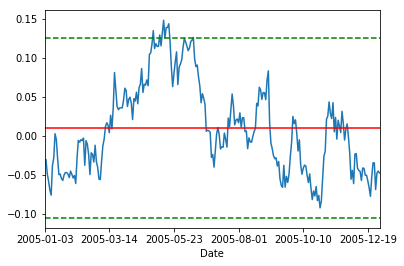

In [181]:
spread = df_ind['LISN']['2005-01':'2006-01'] - df_ind['METN']['2005-01':'2006-01']
mean = np.mean(spread)
stdev = np.std(spread)
upper = mean+2*stdev
lower = mean-2*stdev
spread.plot()
plt.axhline(mean, color='r', linestyle='-')
plt.axhline(upper, color='g', linestyle='--')
plt.axhline(lower, color='g', linestyle='--')

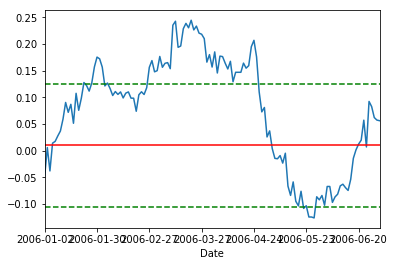

In [180]:
first_period = (1 + df['2006-01':'2006-07'].pct_change()).cumprod()
first_period_spread = df_ind['LISN']['2006-01':'2006-07'] - df_ind['METN']['2006-01':'2006-07']

first_period_spread.plot()

plt.axhline(mean, color='r', linestyle='-')
plt.axhline(mean+2*stdev, color='g', linestyle='--')
plt.axhline(mean-2*stdev, color='g', linestyle='--')

In [187]:
bt_df = pd.DataFrame()

In [193]:
bt_df['LISN'] = df['LISN']['2006-01':'2006-07']
bt_df['METN'] = df['METN']['2006-01':'2006-07']

bt_df['shortsignal'] = np.where(first_period_spread > upper, 1, 0)
bt_df['longsignal'] = np.where(first_period_spread < lower, 1, 0)
bt_df['closelong'] = np.where(first_period_spread > mean, 1, 0)
bt_df['closeshort'] = np.where(first_period_spread < mean, 1, 0)

In [10]:
backtest = backtest(df, 2, 2.0)

VBSN SFZN :  4 trades were made
['VBSN', 'SFZN']
AEVS VBSN :  0 trades were made
['AEVS', 'VBSN']
2000-01-01 00:00:00 2001-01-01 00:00:00 2001-07-01 00:00:00
AEVS TECN :  2 trades were made
['AEVS', 'TECN']
VBSN SOON :  11 trades were made
['VBSN', 'SOON']
2000-07-01 00:00:00 2001-07-01 00:00:00 2002-01-01 00:00:00
BION SOON :  4 trades were made
['BION', 'SOON']
BANB SOON :  5 trades were made
['BANB', 'SOON']
2001-01-01 00:00:00 2002-01-01 00:00:00 2002-07-01 00:00:00
VBSN STMN :  2 trades were made
['VBSN', 'STMN']
SOON TECN :  8 trades were made
['SOON', 'TECN']
2001-07-01 00:00:00 2002-07-01 00:00:00 2003-01-01 00:00:00
AEVS BANB :  4 trades were made
['AEVS', 'BANB']
BANB STMN :  2 trades were made
['BANB', 'STMN']
2002-01-01 00:00:00 2003-01-01 00:00:00 2003-07-01 00:00:00
NOVN ROG :  0 trades were made
['NOVN', 'ROG']
NOVN STMN :  0 trades were made
['NOVN', 'STMN']
2002-07-01 00:00:00 2003-07-01 00:00:00 2004-01-01 00:00:00
BANB NOVN :  13 trades were made
['BANB', 'NOVN']
VBS

In [392]:
ret = pd.DataFrame(backtest.cum_returns)
ret.index = pd.to_datetime(ret.index)

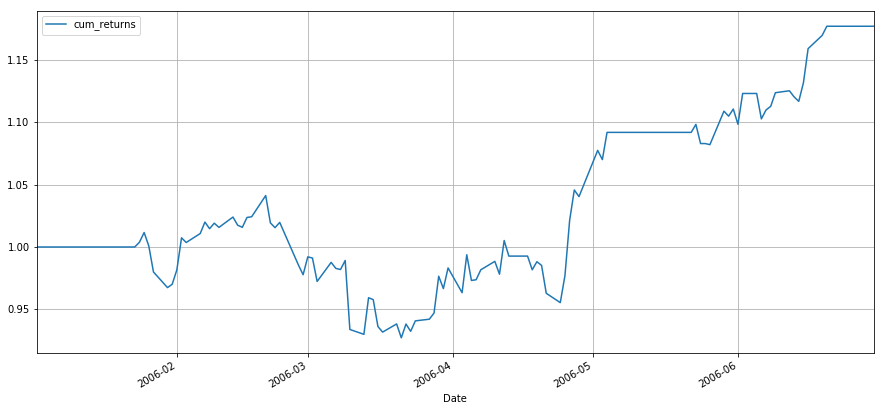

In [393]:
ret.iloc[0] = 1
ret.plot(figsize=(15,7),grid=True)

In [228]:
perf = ret.calc_stats() 
perf.display()

Stat                 cum_returns
-------------------  -------------
Start                2006-01-02
End                  2006-06-30
Risk-free rate       0.00%

Total Return         17.69%
Daily Sharpe         1.63
Daily Sortino        2.83
CAGR                 39.41%
Max Drawdown         -10.95%
Calmar Ratio         3.60

MTD                  5.97%
3m                   21.74%
6m                   -
YTD                  17.69%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  39.41%

Daily Sharpe         1.63
Daily Sortino        2.83
Daily Mean (ann.)    34.26%
Daily Vol (ann.)     20.98%
Daily Skew           0.01
Daily Kurt           3.28
Best Day             4.52%
Worst Day            -5.59%

Monthly Sharpe       4.53
Monthly Sortino      inf
Monthly Mean (ann.)  47.70%
Monthly Vol (ann.)   10.52%
Monthly Skew         -0.55
Monthly Kurt         -3.21
Best Month           6.75%
Worst Month          0.55%

Yearly Sharpe    

C:\Users\jango\Anaconda3\envs\research\lib\site-packages\ffn\core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


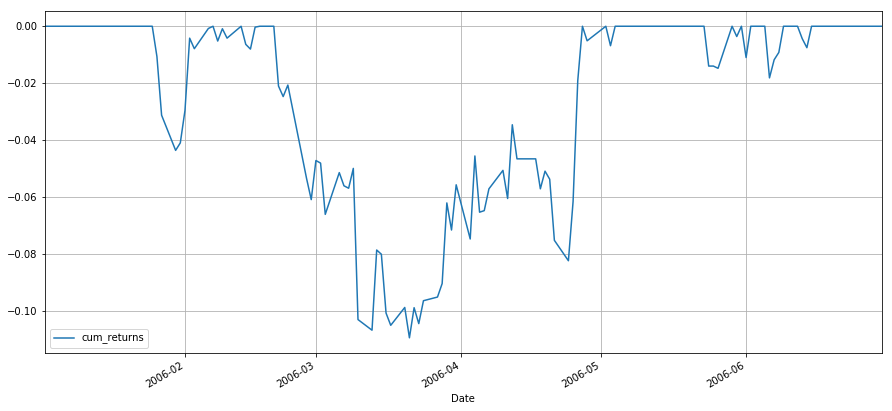

In [229]:
ffn.to_drawdown_series(ret).plot(figsize=(15,7),grid=True) 

Start date,2001-01-03
End date,2019-12-30
Total months,228
,Backtest
Annual return,3.5%
Cumulative returns,91.8%
Annual volatility,3.1%
Sharpe ratio,1.10
Calmar ratio,0.64
Stability,0.91
Max drawdown,-5.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.43,2011-11-01,2014-01-22,2015-03-05,873
1,4.78,2006-03-07,2007-09-07,2008-01-24,493
2,2.86,2016-04-01,2017-05-10,2018-08-21,623
3,2.79,2003-09-16,2004-08-16,2005-07-18,480
4,2.46,2001-11-22,2002-01-21,2002-02-06,55


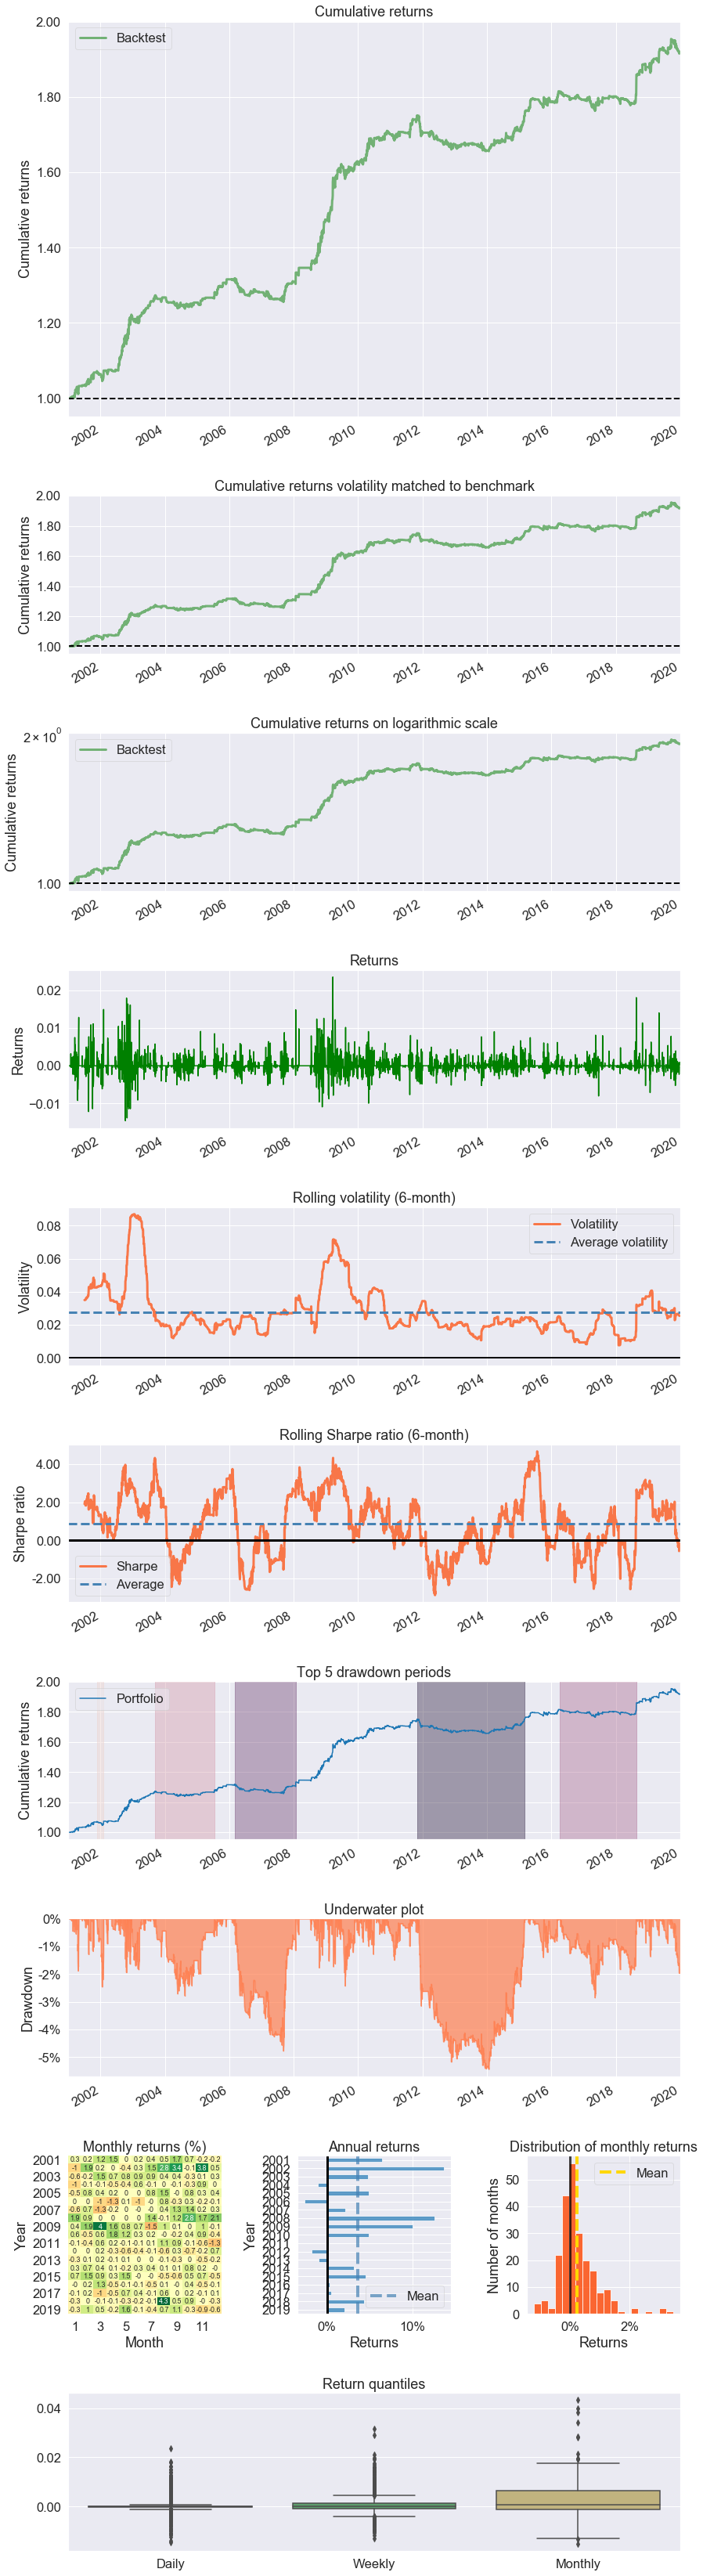

ValueError: cannot reindex from a duplicate axis

In [21]:
pf.create_full_tear_sheet(master_lst['10ssd2.0std'], benchmark_rets=None)